## Example of a training a (single-task) profile model in PyTorch

**Author:** Alex Tseng (amtseng@stanford.edu)

In [11]:
import os
os.chdir('/home/katie/profile_model_example_torch/')

In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyfaidx
import pyBigWig
import profile_models
from profile_models import place_tensor
import profile_performance
import tqdm

In [2]:
# If needed, download the human genome
!test ! -f data/genomes/hg38.fasta && \
    mkdir -p data/genomes && \
    wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz -O data/genomes/hg38.fasta.gz && \
    gunzip data/genomes/hg38.fasta.gz

In [7]:
# Define constants and paths
reference_fasta_path = "data/genomes/hg38.fasta"
peak_bed_path = "data/SPI1_ENCSR000BGQ_GM12878_all_peakints.bed.gz"
tf_neg_bw_path = "data/SPI1_ENCSR000BGQ_GM12878_neg.bw"
tf_pos_bw_path = "data/SPI1_ENCSR000BGQ_GM12878_pos.bw"
cont_neg_bw_path = "data/control_ENCSR000BGH_GM12878_neg.bw"
cont_pos_bw_path = "data/control_ENCSR000BGH_GM12878_pos.bw"

# Create dictionary with paths to pass as arguments to Dataset constructor
kwargs = {'reference_fasta_path':reference_fasta_path,'peak_bed_path':peak_bed_path,'tf_neg_bw_path':tf_neg_bw_path,
          'tf_pos_bw_path':tf_pos_bw_path,'cont_neg_bw_path':cont_neg_bw_path,'cont_pos_bw_path':cont_pos_bw_path}

input_length = 2114
profile_length = 1000

train_chroms = ["chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr9", "chr11", "chr12", "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr19", "chr20", "chr21", "chr22", "chrX"]
val_chroms = ["chr8", "chr10"]
test_chroms = ["chr1"]

counts_loss_weight = 20
learning_rate = 0.001
num_epochs = 5

### Data loading

In [8]:
def dna_to_one_hot(seqs):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)
    seq_concat = "".join(seqs).upper() + "ACGT"
    one_hot_map = np.identity(5)[:, :-1]
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85
    _, base_inds = np.unique(base_vals, return_inverse=True)
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))

# Add dna_to_one_hot to the kwargs dictionary so it will be another member of Dataset
kwargs['dna_to_one_hot'] = dna_to_one_hot

In [9]:
class BPDataset(torch.utils.data.Dataset):
    def __init__(self, coords, batch_size=128, jitter=128, revcomp=True,**kwargs):
        """
        Creates a data loader. `coords` is an N x 3 object array of summit-
        centered coordinates.
        """
        self.coords = coords
        self.batch_size = batch_size
        self.jitter = jitter
        self.revcomp = revcomp
        for k,v in kwargs.items():
            setattr(self,k,v)

    def __len__(self):
        return int(np.ceil(len(self.coords) / self.batch_size))

    def _get_input_seqs(self, coords_batch):
        """
        For a B x 3 array of coordinates, returns the one-hot-encoded
        sequences as a B x I x 4 array.
        """
        # Pad everything to the right size
        mid = (coords_batch[:, 1] + coords_batch[:, 2]) // 2
        coords_batch[:, 1] = mid - (input_length // 2)
        coords_batch[:, 2] = coords_batch[:, 1] + input_length
        
        # Fetch sequences as strings
        reader = pyfaidx.Fasta(getattr(self,'reference_fasta_path',reference_fasta_path))
        seqs = []
        for chrom, start, end in coords_batch:
            seqs.append(reader[chrom][start:end].seq)
        
        return getattr(self,'dna_to_one_hot',dna_to_one_hot)(seqs)
        
    def _get_profiles(self, coords_batch):
        """
        For a B x 3 array of coordinates, returns the true profiles as a
        B x O x 2 array, and the control profiles as a B x O x 2 array.
        """
        # Pad everything to the right size
        mid = (coords_batch[:, 1] + coords_batch[:, 2]) // 2
        coords_batch[:, 1] = mid - (profile_length // 2)
        coords_batch[:, 2] = coords_batch[:, 1] + profile_length
        
        true_profs = np.empty((len(coords_batch), profile_length, 2))
        cont_profs = np.empty((len(coords_batch), profile_length, 2))
        
        tf_neg_reader = pyBigWig.open(getattr(self,'tf_neg_bw_path',tf_neg_bw_path), "r")
        tf_pos_reader = pyBigWig.open(getattr(self,'tf_pos_bw_path',tf_pos_bw_path), "r")
        cont_neg_reader = pyBigWig.open(getattr(self,'cont_neg_bw_path',cont_neg_bw_path), "r")
        cont_pos_reader = pyBigWig.open(getattr(self,'cont_pos_bw_path',cont_pos_bw_path), "r")
        
        for i, (chrom, start, end) in enumerate(coords_batch):
            true_profs[i, :, 0] = np.nan_to_num(tf_neg_reader.values(chrom, start, end))
            true_profs[i, :, 1] = np.nan_to_num(tf_pos_reader.values(chrom, start, end))
            cont_profs[i, :, 0] = np.nan_to_num(cont_neg_reader.values(chrom, start, end))
            cont_profs[i, :, 1] = np.nan_to_num(cont_pos_reader.values(chrom, start, end))

        tf_neg_reader.close()
        tf_pos_reader.close()
        cont_neg_reader.close()
        cont_pos_reader.close()
        
        return true_profs, cont_profs
        
    def __getitem__(self, index):
        """
        Returns a batch of data as the input sequences, target profiles,
        control profiles, and corresponding coordinates for the batch.
        """
        #import ipdb
        #ipdb.set_trace()
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        coords_batch = self.coords[batch_slice]
        
        # Apply jitter
        if self.jitter:
            jitter_amount = np.random.randint(-self.jitter, self.jitter, size=len(coords_batch))
            coords_batch[:, 1] = coords_batch[:, 1] + jitter_amount
            coords_batch[:, 2] = coords_batch[:, 2] + jitter_amount
            
        input_seqs = self._get_input_seqs(coords_batch)
        true_profs, cont_profs = self._get_profiles(coords_batch)
        
        # Reverse-complement augmentation
        if self.revcomp:
            input_seqs = np.concatenate([input_seqs, np.flip(input_seqs, axis=(1, 2))])
            true_profs = np.concatenate([true_profs, np.flip(true_profs, axis=(1, 2))])
            cont_profs = np.concatenate([cont_profs, np.flip(cont_profs, axis=(1, 2))])
            coords_batch = np.concatenate([coords_batch, coords_batch])
        
        return input_seqs.astype(np.float32), true_profs.astype(np.float32), cont_profs.astype(np.float32)#, coords_batch
    
    def on_epoch_start(self):
        # Shuffle the dataset
        inds = np.random.permutation(len(self.coords))
        self.coords = self.coords[inds]
    

In [12]:
peak_table = pd.read_csv(
    peak_bed_path, sep="\t", header=None, index_col=False,
    names=[
        "chrom", "peak_start", "peak_end", "name", "score",
        "strand", "signal", "pval", "qval", "summit_offset"
    ]
)

peak_table["start"] = peak_table["peak_start"] + peak_table["summit_offset"]
peak_table["end"] = peak_table["start"] + 1

In [13]:
all_coords = peak_table[["chrom", "start", "end"]].values
train_coords = all_coords[np.isin(all_coords[:, 0], train_chroms)]
val_coords = all_coords[np.isin(all_coords[:, 0], val_chroms)]
test_coords = all_coords[np.isin(all_coords[:, 0], test_chroms)]

In [14]:
# create class for pinning memory when loading batches in parallel
# use this class for collate_fn argument to torch DataLoader

class SimplePinningBatch:
    def __init__(self, data):
        data_tuple = data[0]
        self.input_seqs = torch.tensor(data_tuple[0]).float()
        self.true_profs = torch.tensor(np.expand_dims(data_tuple[1],axis=1)).float()
        self.cont_profs = torch.tensor(np.expand_dims(data_tuple[2],axis=1)).float()
    # custom memory pinning method on custom type
    def pin_memory(self):
        self.input_seqs = self.input_seqs.pin_memory()
        self.true_profs = self.true_profs.pin_memory()
        self.cont_profs = self.cont_profs.pin_memory()
        return self
def collate_wrapper(batch):
    return SimplePinningBatch(batch)


In [15]:
# Create Datasets and construct DataLoaders with multiple workers
num_workers = 15

train_dset = BPDataset(train_coords,**kwargs)
val_dset = BPDataset(val_coords,**kwargs)
test_dset = BPDataset(test_coords,**kwargs)

train_loader = torch.utils.data.DataLoader(train_dset,num_workers=15,collate_fn=collate_wrapper,pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dset,num_workers=15,collate_fn=collate_wrapper,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset,num_workers=15,collate_fn=collate_wrapper,pin_memory=True)

### Create model

In [16]:
model = profile_models.ProfilePredictorWithControls(
    input_length=input_length,
    input_depth=4,
    profile_length=profile_length,
    num_tasks=1,
    num_strands=2,
    num_dil_conv_layers=9,
    dil_conv_filter_sizes=([21] + ([3] * 8)),
    dil_conv_stride=1,
    dil_conv_dilations=[2 ** i for i in range(9)],
    dil_conv_depth=64,
    prof_conv_kernel_size=75,
    prof_conv_stride=1
)

In [17]:
device = torch.device(1) if torch.cuda.is_available() \
        else torch.device("cpu")
model = model.to(device)

### Train model

In [20]:
def run_epoch(data_loader, model, mode, optimizer=None):
    if mode == "train":
        model.train()
        torch.set_grad_enabled(True)
    
    batch_losses, prof_losses, count_losses = [], [], []
    
    t_iter = tqdm.tqdm(data_loader, desc="\tLoss: ----")
    for batch in t_iter:
        input_seqs = batch.input_seqs.cuda(device=device, non_blocking=True)
        true_profs = batch.true_profs.cuda(device=device, non_blocking=True)
        cont_profs = batch.cont_profs.cuda(device=device, non_blocking=True)
        
        logit_pred_profs, log_pred_counts = model(
            input_seqs,
            cont_profs
        )
        
        loss, prof_loss, count_loss = model.correctness_loss(
            true_profs,
            logit_pred_profs, log_pred_counts,
            counts_loss_weight, return_separate_losses=True
        )
          
        if mode == "train":
            optimizer.zero_grad()
            loss.backward()  # Compute gradient
            optimizer.step()  # Update weights through backprop

        batch_losses.append(loss.item())
        prof_losses.append(prof_loss.item())
        count_losses.append(count_loss.item())
        t_iter.set_description(
            "\tLoss: %6.4f" % loss.item()
        )
    return batch_losses, prof_losses, count_losses

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = {}
val_losses = {}
for key in ("batch", "prof", "count"):
    train_losses[key] = []
    val_losses[key] = []

best_val_loss, best_model_state = float("inf"), model.state_dict()

for epoch_num in range(num_epochs):
    # permute Datasets inside DataLoaders
    train_dset.on_epoch_start()
    val_dset.on_epoch_start()
    
    # Train
    batch_losses, prof_losses, count_losses = run_epoch(
        train_loader, model, "train", optimizer
    )
    
    train_losses["batch"].append(batch_losses)
    train_losses["prof"].append(prof_losses)
    train_losses["count"].append(count_losses)
    print("Train epoch %d loss: %.6f" % (epoch_num + 1, np.nanmean(batch_losses)))
    
    # Valid
    batch_losses, prof_losses, count_losses = run_epoch(
        val_loader, model, "eval", None
    )
    
    val_losses["batch"].append(batch_losses)
    val_losses["prof"].append(prof_losses)
    val_losses["count"].append(count_losses)
    
    val_epoch_loss = np.nanmean(batch_losses)
    print("Valid epoch %d loss: %.6f" % (epoch_num + 1, val_epoch_loss))
    
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_model_state = model.state_dict()
        
model.load_state_dict(best_model_state)

	Loss: ----:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch 1 loss: 376.995571


	Loss: ----:   0%|          | 0/280 [00:00<?, ?it/s]

Valid epoch 1 loss: 289.205897


	Loss: ----:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch 2 loss: 259.733350


	Loss: ----:   0%|          | 0/280 [00:00<?, ?it/s]

Valid epoch 2 loss: 249.156827


	Loss: ----:   0%|          | 0/33 [00:00<?, ?it/s]

Train epoch 3 loss: 243.464005


	Loss: ----:   0%|          | 0/280 [00:00<?, ?it/s]

Valid epoch 3 loss: 241.675370


	Loss: 249.2639:  77%|███████▋  | 215/280 [00:20<00:05, 10.87it/s]

### Performance evaluation

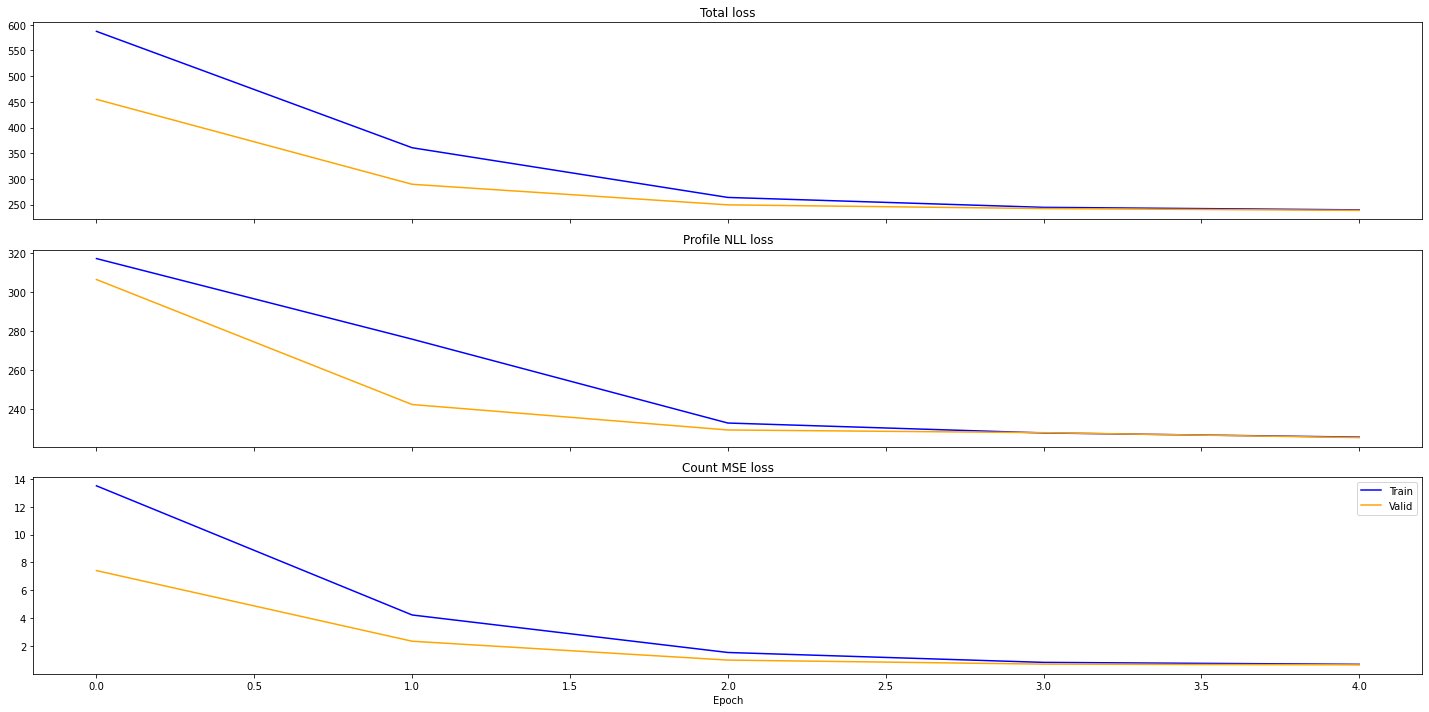

In [17]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(20, 10))
for i, (key, name) in enumerate([
    ("batch", "Total"),
    ("prof", "Profile NLL"),
    ("count", "Count MSE")
]):
    ax[i].plot([np.nanmean(sl) for sl in train_losses[key]], color="blue", label="Train")
    ax[i].plot([np.nanmean(sl) for sl in val_losses[key]], color="orange", label="Valid")
    ax[i].set_title("%s loss" % name)

ax[-1].set_xlabel("Epoch")
plt.legend()
fig.tight_layout()

In [18]:
def profile_logits_to_log_probs(logit_pred_profs, axis=2):
    """
    Converts the model's predicted profile logits into normalized log probabilities
    via a softmax on the specified dimension (defaults to axis=2).
    """
    if type(logit_pred_profs) is np.ndarray:
        return logit_pred_profs - \
            scipy.special.logsumexp(logit_pred_profs, axis=axis, keepdims=True)
    else:
        return torch.log_softmax(logit_pred_profs, dim=axis)

In [19]:
def get_predictions(data_loader, model):
    all_true_profs, all_log_pred_profs, all_true_counts, all_log_pred_counts = [], [], [], []
    
    for batch in tqdm.notebook.tqdm(data_loader):
        input_seqs = batch.input_seqs.cuda(device=device, non_blocking=True)
        true_profs_np = batch.true_profs.numpy()
        cont_profs = batch.cont_profs.cuda(device=device, non_blocking=True)
        
        logit_pred_profs, log_pred_counts = model(
            input_seqs,
            cont_profs
        )
        log_pred_profs = profile_logits_to_log_probs(
            logit_pred_profs
        ).detach()
        
        all_true_profs.append(true_profs_np)
        all_log_pred_profs.append(log_pred_profs.cpu().numpy())
        all_true_counts.append(np.sum(true_profs_np, axis=2))
        all_log_pred_counts.append(log_pred_counts.detach().cpu().numpy())

    return np.concatenate(all_true_profs), np.concatenate(all_log_pred_profs), \
        np.concatenate(all_true_counts), np.concatenate(all_log_pred_counts)

In [20]:
true_profs, log_pred_profs, true_counts, log_pred_counts = get_predictions(
    test_loader, model
)

  0%|          | 0/32 [00:00<?, ?it/s]

In [21]:
metrics = profile_performance.compute_performance_metrics(
    true_profs, log_pred_profs, true_counts, log_pred_counts,
    prof_smooth_kernel_sigma=7, prof_smooth_kernel_width=81,
    print_updates=True
)
profile_performance.log_performance_metrics(metrics)

		Computing profile NLL and cross entropy... 0s
		Computing profile JSD... 0s
		Computing profile correlations/MSE... 3s
		Computing count correlations/MSE... 0s
	Test profile NLL: 231.674299
	Test profile cross entropy: 6.163803
	Test profile JSD: 0.162841
	Test profile Pearson: 0.650860
	Test profile Spearman: 0.578930
	Test profile MSE: 0.000002
	Test count Pearson: 0.393617
	Test count Spearman: 0.400612
	Test count MSE: 0.653407


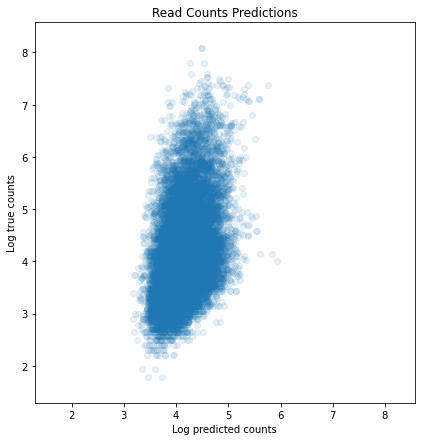

In [22]:
plt.figure(figsize = (7,7))
log_true_counts = np.log(true_counts + 1)
plt.scatter(log_pred_counts, log_true_counts, alpha=0.1)
plt.xlabel("Log predicted counts")
plt.ylabel("Log true counts")

total_max = max(np.max(log_pred_counts), np.max(log_true_counts)) + 0.5
total_min = min(np.min(log_pred_counts), np.min(log_true_counts)) - 0.5
plt.xlim([total_min, total_max])
plt.ylim([total_min, total_max])
plt.gca().set_aspect("equal")
plt.title("Read Counts Predictions")
plt.show()

In [24]:
def plot_profiles(true_profs, pred_profs):
    assert len(pred_profs.shape) == 3
    assert pred_profs.shape == true_profs.shape
    num_tasks, prof_length, _ = pred_profs.shape
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 2))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    plt.show()

Example 7136


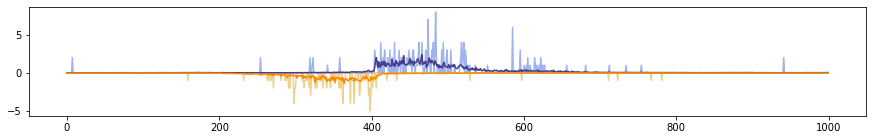

Example 624


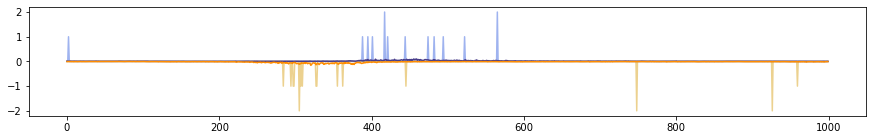

Example 5718


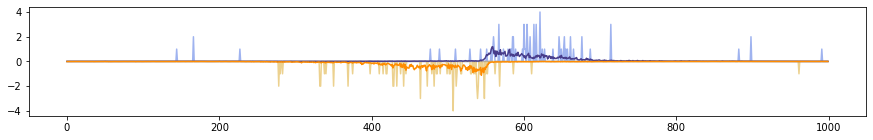

Example 7714


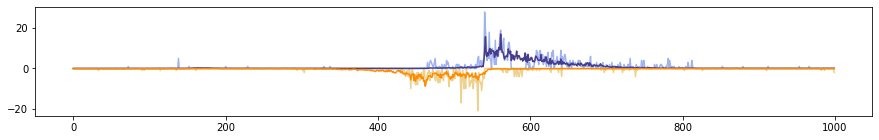

Example 4223


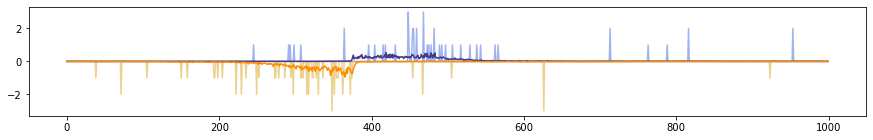

In [25]:
rng = np.random.RandomState(20210405)
example_inds = rng.choice(len(true_profs), size=min(5, len(true_profs)), replace=False)
for i in example_inds:
    print("Example %d" % i)
    plot_profiles(true_profs[i], np.exp(log_pred_profs[i]) * np.sum(true_profs[i], axis=1, keepdims=True))